In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

# Moving ratings data

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [5]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


### Dot product basics

In [ ]:
a = T( [[1., 2], [3, 4]] )
b = T( [[2., 2], [10, 10]] )

In [ ]:
a

In [ ]:
b

In [ ]:
a * b

##### Dot product is ...

In [ ]:
(a * b).sum(1) # sum across the columns

### Formally in Pytorch

PyTorch uses the concept of `module` which can be used independently, but also cna be used as a layer in a `NN`. Model can be invoked with params.

In [ ]:
class DotProduct(nn.Module):
    def forward(self, user, movie):
        return (user * movie).sum(1)

In [ ]:
model = DotProduct()

In [ ]:
model(a, b)

# For real ...

Need to ensure that the numbers do not get too big for gradient descent. So, we ensure the scale of the random initialization is low. There is a formula to that - [Kaiming He method](http://www.jefkine.com/deep/2016/08/08/initialization-of-deep-networks-case-of-rectifiers/). `Note : Pytorch has this initialization built in.` However, as we are trying to learn doing this from scratch, we won't use it.

**Note:** In this case, n1 = 50 (The number of factors of the embedding matrices, which are the inputs to this layer)

In [ ]:
class EmbeddingDot(nn.Module):
    def __init__(self, no_of_users, no_of_movies, no_of_factors):
        super().__init__()
        self.u = nn.Embedding(no_of_users, no_of_factors) # rows = no_of_users, columns = no_of_factors
        self.m = nn.Embedding(no_of_movies, no_of_factors)
        # self.u.weight is a PyToych variable. A Pytorch variable does similar things as tensor but it also
        # does **differentiation**.
        # self.u.weight.data is the tensor representing the enbedded matrix
        self.u.weight.data.uniform_(0, 0.05) # initialize this else we may get very large random numbers
        self.m.weight.data.uniform_(0, 0.05) # uniform_ does an inplace update with the random numbers
    
    
    def forward(self, categories, continuous):
        users = categories[:, 0] # will be a mini-batch(Thx to Pytorch) of users/movies

        movies = categories[:, 1] # will be a mini-batch(Thx to Pytorch) of users/movies

#         return dot_product(self.u(users), self.m(movies)) # user the mini-batch to lookup on the embedded matrices
        u, m = self.u(users), self.m(movies)
        return (u * m).sum(1)
    
    
#     def dot_product(mat1, mat2):
#         return (mat1 * mat2).sum(1)    

##### **NOTE** : If you `loop through a mini-batch`, GPU `accelration is not possible`

#### As user id and movie id is not contiguous...

In [ ]:
user_unique = ratings.userId.unique()
user2idx = {user:index for index, user in enumerate(user_unique)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

In [ ]:
ratings.userId[:10]

In [ ]:
movie_unique = ratings.movieId.unique()
movie2idx = {movie:index for index, movie in enumerate(movie_unique)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [ ]:
ratings.movieId[:10]

In [ ]:
no_of_users = int(ratings.userId.nunique())
no_of_movies = int(ratings.movieId.nunique())
print("Users : {0}, movies : {1}".format(no_of_users, no_of_movies))


#### Input data

In [ ]:
x = ratings.drop(['rating', 'timestamp'], axis=1)
y = ratings['rating'].astype(np.float32)

In [ ]:
x[:10]

In [ ]:
y[:5]

### Train

In [ ]:
val_idxs = get_cv_idxs(len(ratings))
wd = 1e-5
no_of_factors = 50

In [ ]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], bs=64)

In [ ]:
model = EmbeddingDot(no_of_users, no_of_movies, no_of_factors).cuda()

In [ ]:
optimizer = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

##### We are using the fast.ai `fit` method which is nothing but a training loop. We are not using the learner, so there is no SGDR, multiple LR's etc.

In [ ]:
fit(model, data, 3, optimizer, F.mse_loss) 

##### Mimic different learning rates

In [ ]:
set_lrs(optimizer, 0.01)

In [ ]:
fit(model, data, 3, optimizer, F.mse_loss)

## Bias

In [ ]:
min_rating, max_rating = ratings.rating.min(), ratings.rating.max()
min_rating, max_rating

In [ ]:
def get_embedding(no_of_inputs, no_of_factors):
    emb = nn.Embedding(no_of_inputs, no_of_factors)
    emb.weight.data.uniform_(0.01, 0.01)
    return emb
    
class EmbeddingDotBias(nn.Module):
    def __init__(self, no_of_users, no_of_movies, no_of_factors):
        super().__init__()
        (self.users, self.movies, self.user_bias, self.movie_bias) = [get_embedding(*values) for values in 
                                                                      [(no_of_users, no_of_factors), 
                                                                       (no_of_movies, no_of_factors), 
                                                                       (no_of_users, 1), 
                                                                       (no_of_movies, 1)]]
        
    def forward(self, categories, continuous):
        users, movies = categories[:, 0], categories[:, 1]
        dot_prod = (self.users(users) * self.movies(movies)).sum(1)
        # squeeze() adds a vector (bias) to a matrix by duplicating the bias to match the matrix dimension (called as broadcasting)
        response = dot_prod + self.user_bias(users).squeeze() + self.movie_bias(movies).squeeze()
        # Optional, but good to have
        # As ratings are between 1 to 5, we use a sigmoid function to restrict the result to 0 to 1
        # and then multipy it by 4 and add by 1 to make max as 5
        # e.g.: sigmoid(result) = .6, .6*4 = 2.4, 2.4+1 = 3.4
        return (F.sigmoid(response) * (max_rating - min_rating)) + min_rating
        #return response

In [ ]:
wd = 2e-4

In [ ]:
model = EmbeddingDotBias(no_of_users, no_of_movies, no_of_factors).cuda() # Put it on the **GPU**
optimizer = optim.SGD(model.parameters(), lr=1e-1, weight_decay=wd, momentum=0.9)

In [ ]:
fit(model, data, 3, optimizer, F.mse_loss)

In [ ]:
set_lrs(optimizer, 1e-2)

In [ ]:
fit(model, data, 3, optimizer, F.mse_loss)

## Mini NN

In [ ]:
class EmbeddedNet(nn.Module):
    def __init__(self, no_of_users, no_movies, no_of_factors, no_of_activations=10):
        super().__init__()
        (self.users, self.movies) = [get_embedding(*values) for values in [(no_of_users, no_of_factors), 
                                                                           (no_of_movies, no_of_factors)]]
        self.linear1 = nn.Linear(no_of_factors * 2, no_of_activations) # * 2 because we are merging user and movie embedded columns into one matrix 
        self.linear2 = nn.Linear(no_of_activations, 1) # 1 because we want 1 output, rating.
        
    def forward(self, categories, continuous):
        users, movies = categories[:, 0], categories[:, 1]
        # torc.cat merges users and movies embedding matric columns into one matrix
        response = F.dropout(torch.cat([self.users(users), self.movies(movies)], dim=1), 0.075)
        response = F.dropout(F.relu(self.linear1(response)), 0.75) # .75 is drop out
        return (F.sigmoid(self.linear2(response)) * (max_rating - min_rating)) + min_rating - 0.5
        

In [ ]:
wd = 5e-4

In [ ]:
model = EmbeddedNet(no_of_users, no_of_movies, no_of_factors).cuda()
optimizer = optim.SGD(model.parameters(), 1e-2, weight_decay=wd, momentum=0.9)

In [ ]:
fit(model, data, 3, optimizer, F.mse_loss)

In [ ]:
set_lrs(optimizer, 1e-3)

In [ ]:
fit(model, data, 3, optimizer, F.mse_loss)

### Try adding genere as one more embedding matrix and also timestamp as a continuous parameter

# Analysing results

## Let's use the fast.ai library to train

In [6]:
val_idxs = get_cv_idxs(len(ratings))
wd = 2e-4
no_of_factors = 50
batch_size = 64
lr = 1e-02

In [7]:
dataset = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

In [8]:
learner = dataset.get_learner(no_of_factors, val_idxs, batch_size, opt_fn=optim.Adam)

In [9]:
learner.fit(lr, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.795643   0.808786  
    1      0.77762    0.778394                                  
    2      0.639126   0.764932                                  



[0.7649321]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [10]:
math.sqrt(0.765224)

0.8747708271313122

In [11]:
preds = learner.predict()

In [12]:
y = learner.data.val_y

In [13]:
y

array([3.5, 4. , 3. , ..., 4. , 4. , 3.5], dtype=float32)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


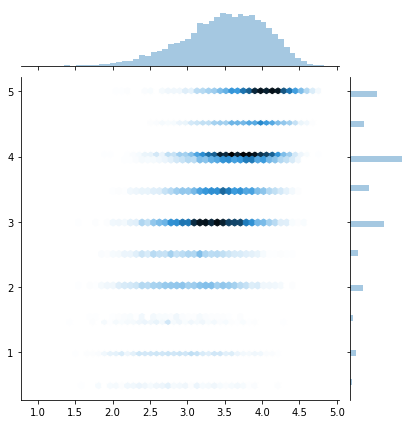

In [14]:
sns.jointplot(preds, y, kind='hex', stat_func=None)

## Movie analysis

In [15]:
movie_names = movies.set_index('movieId')['title'].to_dict()

In [16]:
{print(movie_names[i]) for i in range(1, 6)}

Toy Story (1995)
Jumanji (1995)
Grumpier Old Men (1995)
Waiting to Exhale (1995)
Father of the Bride Part II (1995)


{None}

In [17]:
total_rated_movies = ratings.groupby('movieId')['rating'].count()

In [18]:
top_movie_ids = total_rated_movies.sort_values(ascending=False).index.values[:3000] # top 3000 movies

In [19]:
top_movie_ids[:5]

array([356, 296, 318, 593, 260])

###### It's recommnded to use numpy as much as possible as it's mature and used widely. Use tensors only when required to be on GPU

In [20]:
top_movie_idx = np.array([dataset.item2idx[i] for i in top_movie_ids])

### Movie bias

In [21]:
model = learner.model

In [22]:
model.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

###### Convert to PyTorch variables. They have same interface as tensors. NOTE: Going away on PyTorch 0.4

In [23]:
movie_bias = to_np(model.ib(V(top_movie_idx))) # ib = item bias. In this cases it's movie bias

In [24]:
movie_bias

array([[ 0.76426],
       [ 0.88378],
       [ 1.32854],
       ...,
       [ 0.32111],
       [-0.04019],
       [ 0.22479]], dtype=float32)

In [25]:
movie_ratings = [(bias[0], movie_names[idx]) for bias, idx in zip(movie_bias, top_movie_ids)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [26]:
sorted(movie_ratings, key=lambda x: x[0])[:10]

[(-1.0005959, 'Battlefield Earth (2000)'),
 (-0.7649967, 'Super Mario Bros. (1993)'),
 (-0.75879234, 'Speed 2: Cruise Control (1997)'),
 (-0.7202109, 'Wild Wild West (1999)'),
 (-0.6959061, 'Anaconda (1997)'),
 (-0.6751908, 'Inspector Gadget (1999)'),
 (-0.6634802, 'Superman III (1983)'),
 (-0.631462, 'Congo (1995)'),
 (-0.62483597, 'Bio-Dome (1996)'),
 (-0.62329674, 'Mighty Morphin Power Rangers: The Movie (1995)')]

In [27]:
sorted(movie_ratings, key=lambda x: x[0], reverse=True)[:10]

[(1.3285437, 'Shawshank Redemption, The (1994)'),
 (1.1658663, 'Godfather, The (1972)'),
 (1.0645536, 'Usual Suspects, The (1995)'),
 (1.005928, "Schindler's List (1993)"),
 (0.93536973, 'Godfather: Part II, The (1974)'),
 (0.9161449, 'Fargo (1996)'),
 (0.8837781, 'Pulp Fiction (1994)'),
 (0.8589992, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.8457128, 'To Kill a Mockingbird (1962)'),
 (0.8434523, 'Rear Window (1954)')]

### Embedding intrepretation

In [28]:
movie_emb = to_np(model.i(V(top_movie_idx)))

In [29]:
movie_emb.shape

(3000, 50)

###### As embedding as 50 long, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them to 3 vectors

In [30]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [32]:
movie_pca.shape

(3, 3000)

In [33]:
movie_pca[:, 3]

array([-0.07553, -0.02858,  0.04343], dtype=float32)

#### 1st PCA compoment

In [34]:
factor0 = movie_pca[0]
movies_fac_0 = [(factor, movie_names[i]) for factor, i in zip(factor0, top_movie_ids)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [35]:
sorted(movies_fac_0, key=lambda x: x[0])[:10]
#sorted(movies_fac_0, key=itemgetter(0), reverse=True)[:10]

[(-0.085434094, 'Pulp Fiction (1994)'),
 (-0.07563275, 'Fargo (1996)'),
 (-0.07552979, 'Silence of the Lambs, The (1991)'),
 (-0.073481575, 'Casablanca (1942)'),
 (-0.072361924, 'Chinatown (1974)'),
 (-0.07108262, 'Taxi Driver (1976)'),
 (-0.06429172, 'Shining, The (1980)'),
 (-0.061938766, 'Full Metal Jacket (1987)'),
 (-0.060535647, 'Apocalypse Now (1979)'),
 (-0.058652498, 'Deer Hunter, The (1978)')]

In [36]:
sorted(movies_fac_0, key=lambda x: x[0], reverse=True)[:10]

[(0.06770722, 'Police Academy 3: Back in Training (1986)'),
 (0.06321747, 'Armageddon (1998)'),
 (0.062434454, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.060521595, 'Home Alone 3 (1997)'),
 (0.059526123, 'Waterworld (1995)'),
 (0.05630482, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.054754935, 'Grumpier Old Men (1995)'),
 (0.053716913, 'Gone in 60 Seconds (2000)'),
 (0.05341387, 'Batman Forever (1995)'),
 (0.05173878, 'Lake Placid (1999)')]

#### 2nd PCA component

In [37]:
factor1 = movie_pca[1]
movies_fac_1 = [(factor, movie_names[i]) for factor, i in zip(factor1, top_movie_ids)]

In [38]:
sorted(movies_fac_1, key=lambda x: x[0])[:10]

[(-0.11790525, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.11316099, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.1127283,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.103001274, 'Jurassic Park (1993)'),
 (-0.09515219, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.09181601, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.08916428, 'Forrest Gump (1994)'),
 (-0.08916224, 'Lethal Weapon (1987)'),
 (-0.088437535, 'Spider-Man (2002)'),
 (-0.0797007, 'Lord of the Rings: The Return of the King, The (2003)')]

In [39]:
sorted(movies_fac_1, key=lambda x: x[0], reverse=True)[:10]

[(0.051858075, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.051274497, 'Tank Girl (1995)'),
 (0.04797411, 'English Patient, The (1996)'),
 (0.04774691, 'Coneheads (1993)'),
 (0.043589044, 'Lost Highway (1997)'),
 (0.04234381, 'Battlefield Earth (2000)'),
 (0.041854363, 'Dazed and Confused (1993)'),
 (0.04136378, 'Leaving Las Vegas (1995)'),
 (0.04089437, 'Manhattan (1979)'),
 (0.040883068, 'Jack Frost (1998)')]

##### Let's plot the 2 factors

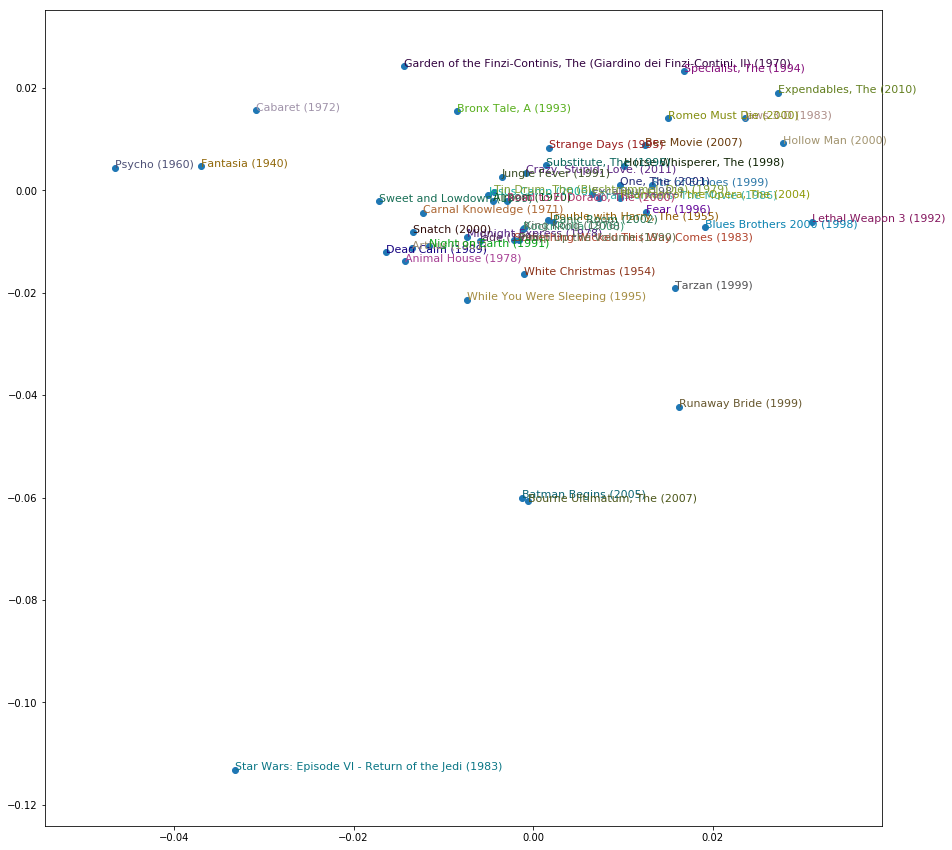

In [41]:
idxs = np.random.choice(len(top_movie_ids), 50, replace=False)
X = factor0[idxs]
Y = factor1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movie_ids[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()